In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags

The one-dimensional heat equation is:

$$ \frac{\partial U(x,t)}{\partial t} = D \frac{\partial^2 U(x,t)}{\partial x^2}$$

Where D is the diffusion coefficient. Let's keep it D=1 for this problem. The initial and boundary conditions of $U(x,t)$ for the interval $x \in[0,L]$  are:

(Dirichlet) Boundary conditions:

* $T_l = T_r = 0$

The initial condition: $f(x) = 4x(1-x)$

Explicit Forward Euler method(FTCS) is:
* $$u_i^{j+1} = (1- 2 \alpha) u_j^i + \alpha (u^j_{i+1} + u^j_{i-1})$$

Where $\alpha = D \frac{\Delta t}{\Delta x^2}$

In [3]:
def ForwardEuler(M,alpha, T =30, L = 1, k = 1): 
    
   
    #M = GRID POINTS on space interval
    N = (M**2) #GRID POINTS on time interval

    
    x0 = 0
    xL = L

    dx = (xL - x0)/(M-1)

    
    t0 = 0
    tF = T 

    
    dt = (tF - t0)/(N-1)

    #alpha = dt*k/dx**2
    
    #grids
    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    
    U = np.zeros((M, N))

    # ----- Initial condition -----
    U[:,0] = 4*xspan*(1-xspan)

    # ----- Boundary conditions -----

    U[0,:] = 0;
    U[-1,:] = 0;
    
    #FTCS-
    for k in range(0, N-1):
        for i in range(1, M-1):
            U[i, k+1] = alpha*U[i-1, k] + (1-2*alpha)*U[i,k] + alpha*U[i+1,k] 
    
    return (U, tspan, xspan)



The implicit BTCS method is :

* $$ - u_i^j = \alpha u^{j+1}_{i+1} - (1+ 2 \alpha) u^{j+1}_i + \alpha u^{j+1}_{i-1}$$

In [4]:
def BackwardEuler(M,alpha, T =30, L = 1, k = 1): 
    
    
    # M = GRID POINTS on space interval
    N = (M**2) #GRID POINTS on time interval

    # ---- Length of the wire in x direction ---- 
    x0, xL = 0, L 

    # ----- Spatial discretization step -----
    dx = (xL - x0)/(M-1)

    # ---- Final time ---- 
    t0, tF = 0, T 

    # ----- Time step -----
    dt = (tF - t0)/(N-1)

    # k = 1.0 Diffusion coefficient
    
    #alpha = dt*k/dx**2
    

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    main_diag = (1 + 2*alpha)*np.ones((1,M-2))
    off_diag = -alpha*np.ones((1, M-3))
    
    
    a = main_diag.shape[1]
    diagonals = [main_diag, off_diag, off_diag]

    #Sparse Matrix diagonals
    A = sparse.diags(diagonals, [0,-1,1], shape=(a,a)).toarray()
  

    # --- Initializes matrix U -----
    U = np.zeros((M, N))

    # ----- Initial condition -----
    U[:,0] = 4*xspan*(1-xspan)

    # ----- Boundary conditions -----
    U[0,:] = 0;
    U[-1,:] = 0;



    for i in range(1, N):
        c = np.zeros((M-4,1)).ravel()
        
        b1 = np.asarray([alpha*U[0,i],alpha*U[-1,i]])
        
        b1 = np.insert(b1, 1, c)
        
        b2 = np.array(U[1:M-1, i-1])
        
        b = b1 + b2  # Right hand side
        
        U[1:M-1, i] = np.linalg.solve(A,b)  # Solve x=A\b
   
    return (U, tspan, xspan)



The Crank-Nicolson Method is:
    
* $$ - \alpha u^{j+1}_{i+1} + 2(1+ \alpha) u^{j+1}_i - \alpha u^{j+1}_{i-1} = \alpha u^{n}_{j+1} + 2(1-\alpha)^j_i + \alpha u^n_{j-1}$$

In [5]:
def CrankNicolson(M, alpha, T = 30, L = 1, k = 1):
    #Parameters needed to solve the equation within the explicit method
    # M = GRID POINTS on space interval
    N = (M**2) #GRID POINTS on time interval

    # ---- Length of the wire in x direction ---- 
    x0, xL = 0, L

    # ----- Spatial discretization step -----
    dx = (xL - x0)/(M-1)

    # ---- Final time ---- 
    t0, tF = 0, T 

    # ----- Time step -----
    dt = (tF - t0)/(N-1)

    #alpha = dt*k/(2.0*dx**2)
    a0 = 1 + 2*alpha
    c0 = 1 - 2*alpha

    xspan = np.linspace(x0, xL, M)
    tspan = np.linspace(t0, tF, N)

    maindiag_a0 = a0*np.ones((1,M-2))
    offdiag_a0 = (-alpha)*np.ones((1, M-3))

    maindiag_c0 = c0*np.ones((1,M-2))
    offdiag_c0 = alpha*np.ones((1, M-3))

    #Left-hand side tri-diagonal matrix
    a = maindiag_a0.shape[1]
    diagonalsA = [maindiag_a0, offdiag_a0, offdiag_a0]
    A = sparse.diags(diagonalsA, [0,-1,1], shape=(a,a)).toarray()
    
   

    #Right-hand side tri-diagonal matrix
    c = maindiag_c0.shape[1]
    diagonalsC = [maindiag_c0, offdiag_c0, offdiag_c0]
    
    Arhs = sparse.diags(diagonalsC, [0,-1,1], shape=(c,c)).toarray()
    

    # ----- Initializes matrix U -----
    U = np.zeros((M, N))
    
    
    # ----- Initial condition -----
    U[:,0] = 4*xspan*(1-xspan)

    # ----- Boundary conditions -----

    U[0,:] = 0;
    U[-1,:] = 0;

        
    for k in range(1, N):
        
        ins = np.zeros((M-4,1)).ravel()
        
        b1 = np.asarray([alpha*U[0,k]+alpha*U[0,k-1],alpha*U[-1,k]+alpha*U[-1,k-1]])
        
        b1 = np.insert(b1, 1, ins)
        
        b2 = np.matmul(Arhs, np.array(U[1:M-1, k-1]))
        
        b = b1 + b2  # Right hand side
        
        U[1:M-1, k] = np.linalg.solve(A,b)  # Solve x=A\b
    
    return (U, tspan, xspan)



Text(0, 0.5, 'U(x,t)')

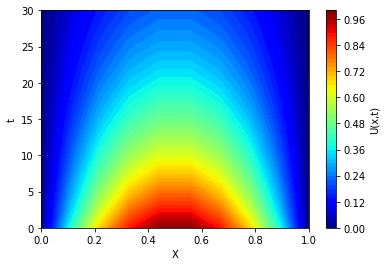

In [20]:
U, tspan, xspan = ForwardEuler(10,1.0/8.0)
U = np.transpose(U)


plt.contourf(xspan,tspan,U, 50, cmap='jet')
cbar = plt.colorbar()
plt.xlabel("X")
plt.ylabel("t")
cbar.ax.set_ylabel("U(x,t)")


Text(0, 0.5, 'U(x,t)')

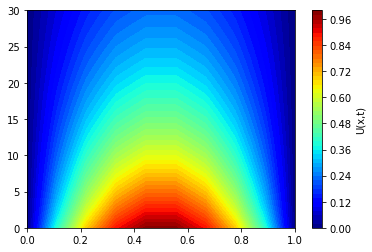

In [21]:
U, tspan, xspan = BackwardEuler(10,1.0/8.0)
U = np.transpose(U)

plt.contourf(xspan,tspan,U, 50, cmap='jet')
cbar = plt.colorbar();
cbar.ax.set_ylabel("U(x,t)")

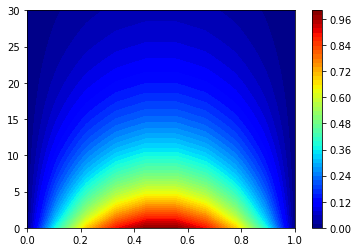

In [22]:
U, tspan, xspan = CrankNicolson(10,1.0/8.0)
U = np.transpose(U)

plt.contourf(xspan,tspan,U, 50, cmap='jet')
plt.colorbar();

In [23]:
from PDEmethods import *

We'll now use the python file "PDEmethods.py" which has functions for 1 Dimensional PDE computation using all the 3 methods for dirichlet and neumann boundary conditons.

In [24]:
def f(x):
    return np.exp(- x**2)

def g(x):
    return x*0

def h(x):
    return x*0


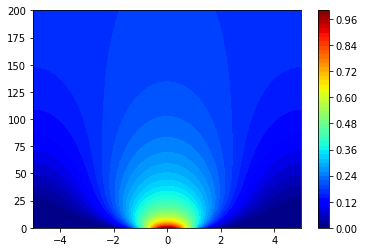

In [25]:
x,t,U = BTCS_Neumann([-5,5],[0,200],0.1,0.05,f,g,h,0.05)


U = np.transpose(U)

plt.contourf(x,t,U, 50, cmap='jet')
plt.colorbar();

In [26]:
def ini(x):
    return 2-1.5*x+np.sin(np.pi*x)

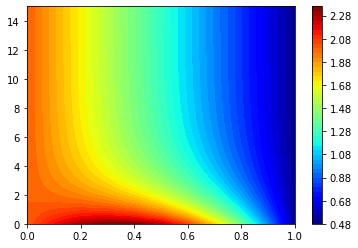

In [27]:
x,t,U = CrankNicolson_Dirichlet([0,1],[0,15],0.1,0.05,ini,2,0.5,0.05)


U = np.transpose(U)

plt.contourf(x,t,U, 50, cmap='jet')
plt.colorbar();